# GMM Temperature Classification - Cold_normal vs Hot

**Note: Sensor 1 is excluded from analysis due to abnormal behavior.**

This notebook implements:
- Loading sensor data (Sensors 2, 3, 4 only - Sensor 1 excluded)
- Statistical feature engineering (mean, std, min, max)
- 70/30 train-test split with stratification
- Feature selection using Mutual Information
- GMM model training (2 components, diagonal covariance)
- Performance evaluation and visualization


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline


## 1. Data Loading


In [ ]:
def load_all_data(data_dir=None):
    """Load all sensor data from Cold_normal and Hot folders.
    Returns file-level data: each file becomes one data point with aggregated features."""
    # Auto-detect the correct path
    if data_dir is None:
        # Try current directory first (if notebook is in Readings folder)
        current_dir = Path('.')
        if (current_dir / 'Cold_normal').exists() and (current_dir / 'Hot').exists():
            data_path = current_dir
        # Try Readings subdirectory (if notebook is in project root)
        elif (current_dir / 'Readings' / 'Cold_normal').exists() and (current_dir / 'Readings' / 'Hot').exists():
            data_path = current_dir / 'Readings'
        else:
            # Try going up one level and then into Readings
            parent_dir = Path('..')
            if (parent_dir / 'Readings' / 'Cold_normal').exists() and (parent_dir / 'Readings' / 'Hot').exists():
                data_path = parent_dir / 'Readings'
            else:
                # Last resort: try absolute path
                import os
                cwd = Path(os.getcwd())
                if (cwd / 'Readings' / 'Cold_normal').exists() and (cwd / 'Readings' / 'Hot').exists():
                    data_path = cwd / 'Readings'
                else:
                    data_path = Path('Readings')  # Default fallback
    else:
        data_path = Path(data_dir)
    
    X_file_level = []  # One feature vector per file
    y_file_level = []  # One label per file
    
    print(f"Searching for data in: {data_path.absolute()}")
    
    # Load Cold_normal data
    cold_folder = data_path / 'Cold_normal'
    if cold_folder.exists():
        csv_files = sorted(cold_folder.glob('raw_sensor_log*.csv'))
        print(f"Loading {len(csv_files)} files from {cold_folder}...")
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                # Extract sensor readings (Sensor 1 excluded due to abnormal behavior)
                sensor_data = df[['Sensor_2', 'Sensor_3', 'Sensor_4']].values.astype(float)
                X_file_level.append(sensor_data)
                y_file_level.append('Cold_normal')
            except Exception as e:
                print(f"  Error loading {csv_file.name}: {e}")
    else:
        print(f"Warning: Cold_normal folder not found at {cold_folder.absolute()}")
    
    # Load Hot data
    hot_folder = data_path / 'Hot'
    if hot_folder.exists():
        csv_files = sorted(hot_folder.glob('raw_sensor_log*.csv'))
        print(f"Loading {len(csv_files)} files from {hot_folder}...")
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                # Extract sensor readings (Sensor 1 excluded due to abnormal behavior)
                sensor_data = df[['Sensor_2', 'Sensor_3', 'Sensor_4']].values.astype(float)
                X_file_level.append(sensor_data)
                y_file_level.append('Hot')
            except Exception as e:
                print(f"  Error loading {csv_file.name}: {e}")
    else:
        print(f"Warning: Hot folder not found at {hot_folder.absolute()}")
    
    if not X_file_level:
        print(f"\nError: No data files found. Searched in: {data_path}")
        print(f"Current working directory: {Path.cwd()}")
        return None, None
    
    # X_file_level is a list of arrays, where each array contains all rows from one file
    # y_file_level is the labels (one per file)
    y = np.array(y_file_level)
    return X_file_level, y

# Load data at file level
# Try to auto-detect the correct path
# If auto-detection fails, you can manually specify the path:
# X_file_data, y = load_all_data(data_dir='../Readings')  # If running from Readings folder
# X_file_data, y = load_all_data(data_dir='Readings')     # If running from project root
# X_file_data, y = load_all_data(data_dir='.')          # If data folders are in current directory

X_file_data, y = load_all_data()  # X_file_data is list of arrays (one array per file)

if X_file_data is not None:
    print(f"\nTotal files: {len(X_file_data)}")
    print(f"Rows per file: {[len(x) for x in X_file_data[:5]]}... (showing first 5)")
    
    print(f"\nFile-level class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"  {cls}: {cnt} files ({cnt/len(y)*100:.1f}%)")
else:
    print("\nERROR: Failed to load data. Please check:")
    print("  1. The Cold_normal and Hot folders exist")
    print("  2. The folders contain CSV files starting with 'raw_sensor_log'")
    print("  3. The current working directory is correct")


Searching for data in: c:\Users\aditj\New Projects\IIT_Internship\Readings
Loading 25 files from Cold_normal...
Loading 25 files from Hot...

Total files: 50
Rows per file: [226, 226, 226, 226, 226]... (showing first 5)

File-level class distribution:
  Cold_normal: 25 files (50.0%)
  Hot: 25 files (50.0%)


## 1.1 Raw Data Visualization

Visualize the raw sensor data before feature engineering to understand the data distribution and differences between Cold_normal and Hot classes.


RAW DATA VISUALIZATION

Cold_normal files: 25
Hot files: 25


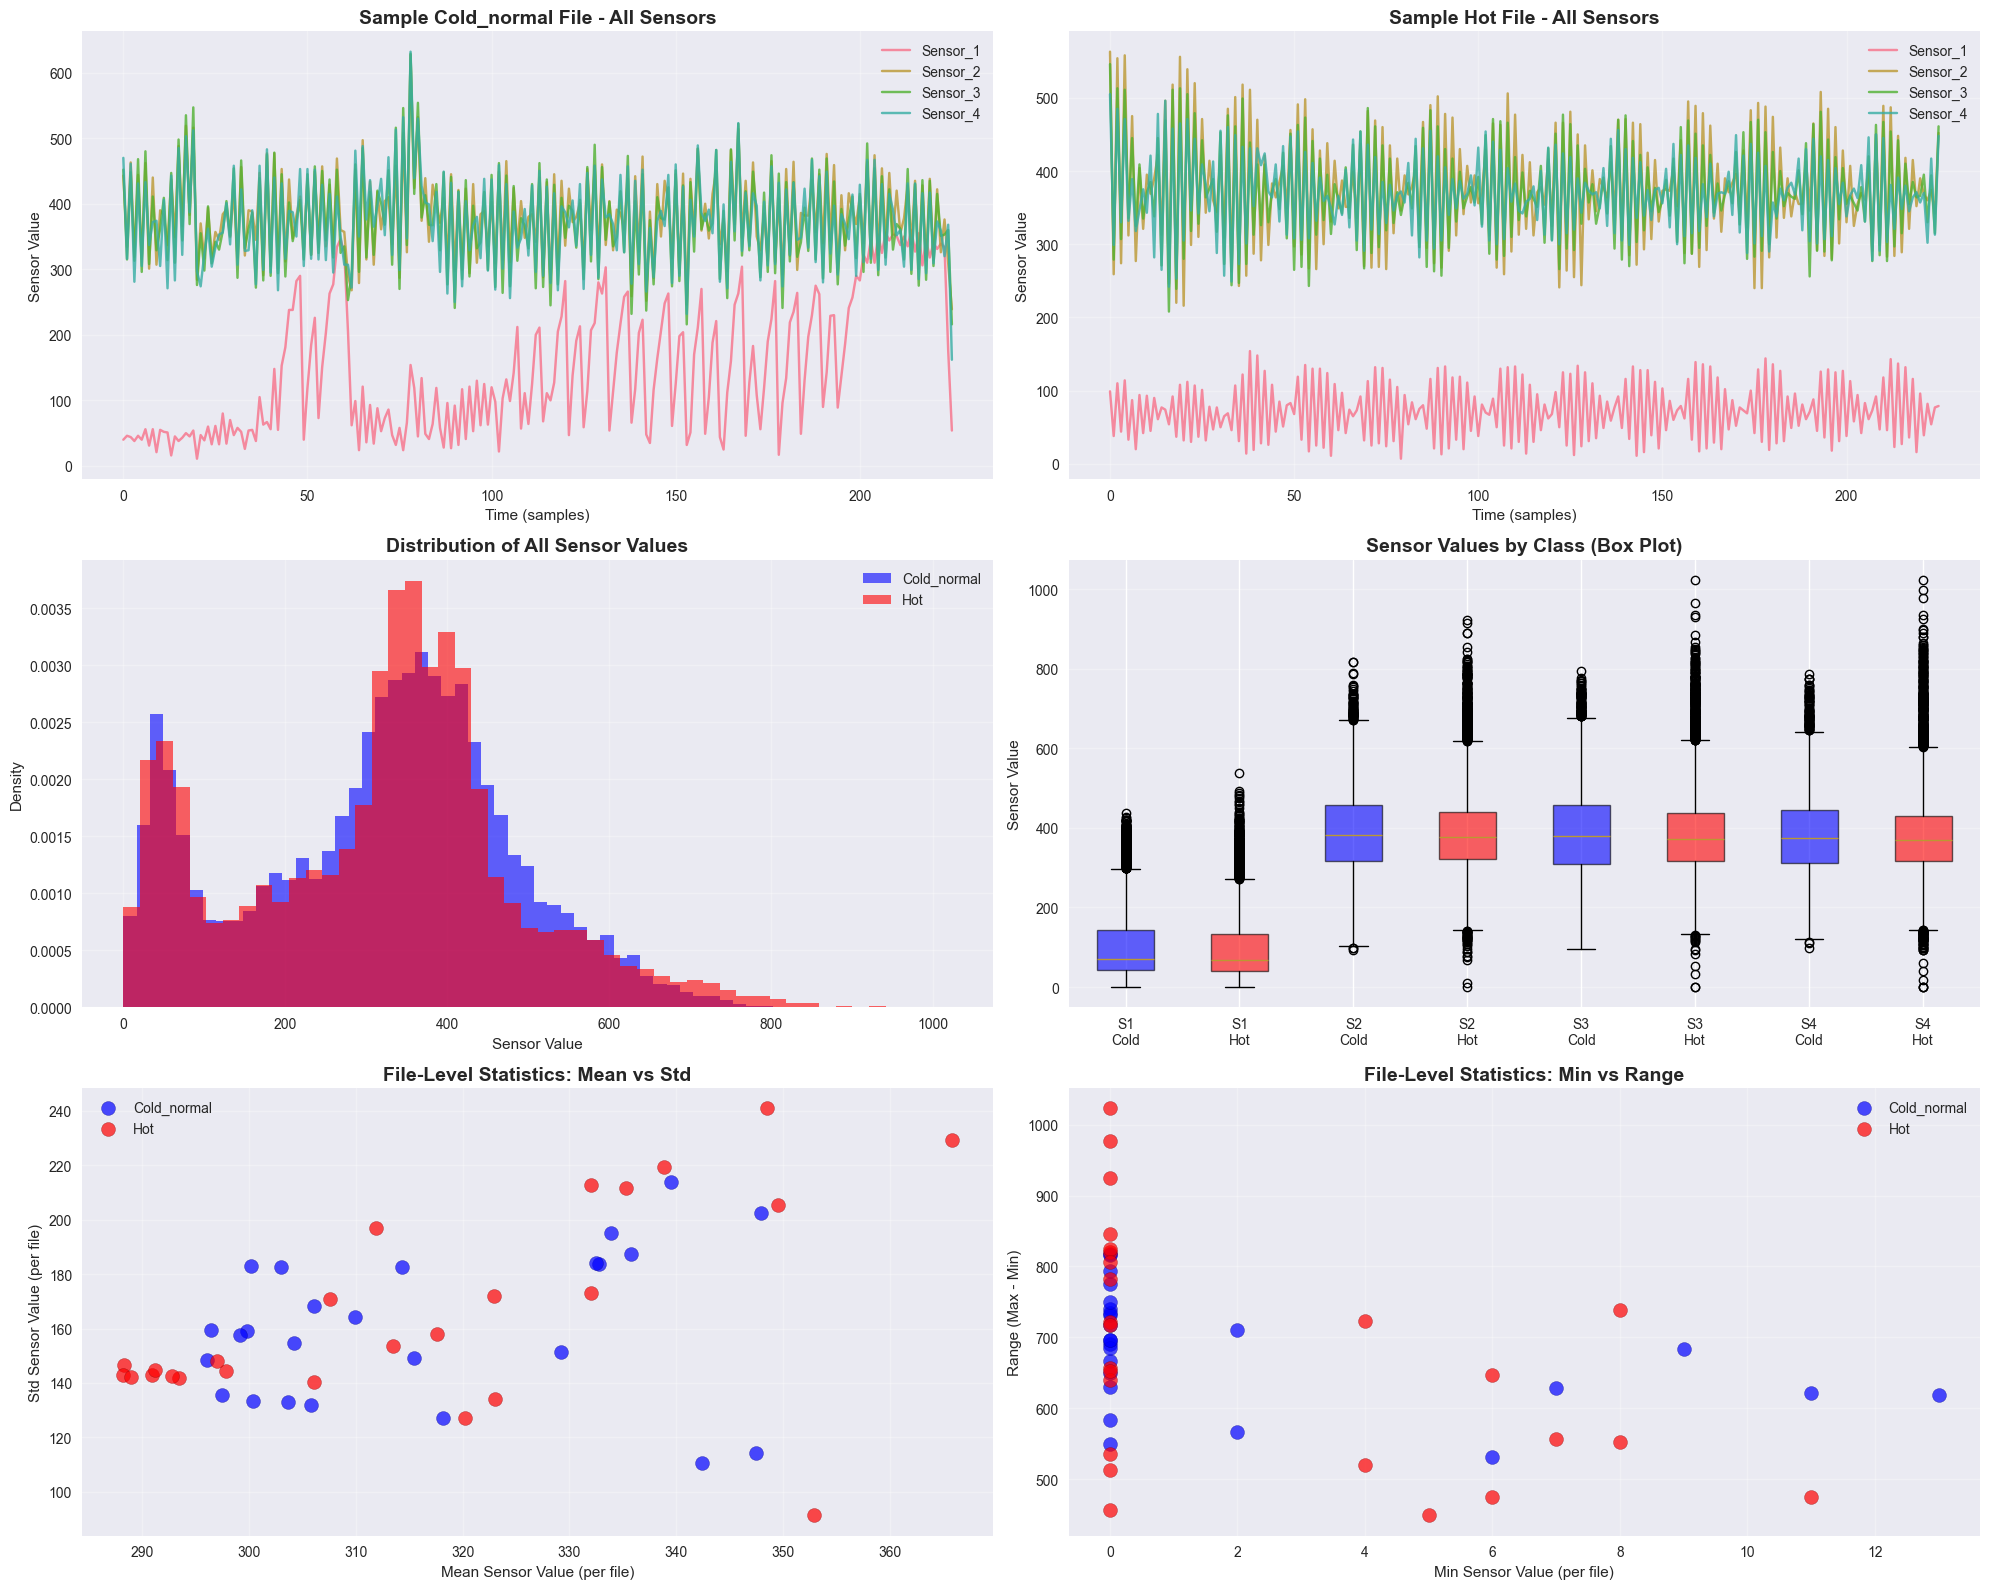


✓ Raw data visualization saved as 'raw_data_visualization.png'


In [ ]:
# ============================================================================
# RAW DATA VISUALIZATION
# ============================================================================

print("="*80)
print("RAW DATA VISUALIZATION")
print("="*80)

# Separate data by class
cold_data = [X_file_data[i] for i in range(len(y)) if y[i] == 'Cold_normal']
hot_data = [X_file_data[i] for i in range(len(y)) if y[i] == 'Hot']

print(f"\nCold_normal files: {len(cold_data)}")
print(f"Hot files: {len(hot_data)}")

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# ============================================================================
# 1. Sample Time Series - Cold_normal vs Hot (Sensors 2, 3, 4 - Sensor 1 excluded)
# ============================================================================
ax1 = fig.add_subplot(3, 2, 1)
sample_cold = cold_data[0]
time_axis = np.arange(len(sample_cold))
for i, sensor in enumerate(['Sensor_2', 'Sensor_3', 'Sensor_4']):
    ax1.plot(time_axis, sample_cold[:, i], label=sensor, alpha=0.8)
ax1.set_xlabel('Time (samples)')
ax1.set_ylabel('Sensor Value')
ax1.set_title('Cold_normal - Sensors 2,3,4', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(3, 2, 2)
sample_hot = hot_data[0]
time_axis = np.arange(len(sample_hot))
for i, sensor in enumerate(['Sensor_2', 'Sensor_3', 'Sensor_4']):
    ax2.plot(time_axis, sample_hot[:, i], label=sensor, alpha=0.8)
ax2.set_xlabel('Time (samples)')
ax2.set_ylabel('Sensor Value')
ax2.set_title('Hot - Sensors 2,3,4', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

# ============================================================================
# 2. Distribution Comparison - All Sensor Values
# ============================================================================
ax3 = fig.add_subplot(3, 2, 3)
# Flatten all values for each class
cold_all_values = np.concatenate([d.flatten() for d in cold_data])
hot_all_values = np.concatenate([d.flatten() for d in hot_data])

ax3.hist(cold_all_values, bins=50, alpha=0.6, label='Cold_normal', color='blue', density=True)
ax3.hist(hot_all_values, bins=50, alpha=0.6, label='Hot', color='red', density=True)
ax3.set_xlabel('Sensor Value')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of All Sensor Values', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# ============================================================================
# 3. Box Plot - Per Sensor Comparison (Sensors 2, 3, 4)
# ============================================================================
ax4 = fig.add_subplot(3, 2, 4)
box_data = []
labels = []
colors = []
sensor_names = ['S2', 'S3', 'S4']
for sensor_idx in range(3):
    cold_sensor = np.concatenate([d[:, sensor_idx] for d in cold_data])
    hot_sensor = np.concatenate([d[:, sensor_idx] for d in hot_data])
    box_data.extend([cold_sensor, hot_sensor])
    labels.extend([f'{sensor_names[sensor_idx]}\nCold', f'{sensor_names[sensor_idx]}\nHot'])
    colors.extend(['blue', 'red'])

bp = ax4.boxplot(box_data, labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax4.set_ylabel('Sensor Value')
ax4.set_title('Sensor Values by Class', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

# ============================================================================
# 4. Mean Values per File - Scatter Plot
# ============================================================================
ax5 = fig.add_subplot(3, 2, 5)
cold_means = np.array([d.mean() for d in cold_data])
hot_means = np.array([d.mean() for d in hot_data])
cold_stds = np.array([d.std() for d in cold_data])
hot_stds = np.array([d.std() for d in hot_data])

ax5.scatter(cold_means, cold_stds, c='blue', s=100, alpha=0.7, label='Cold_normal', edgecolors='darkblue')
ax5.scatter(hot_means, hot_stds, c='red', s=100, alpha=0.7, label='Hot', edgecolors='darkred')
ax5.set_xlabel('Mean Sensor Value (per file)')
ax5.set_ylabel('Std Sensor Value (per file)')
ax5.set_title('File-Level Statistics: Mean vs Std', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# ============================================================================
# 5. Range (Max - Min) per File
# ============================================================================
ax6 = fig.add_subplot(3, 2, 6)
cold_ranges = np.array([d.max() - d.min() for d in cold_data])
hot_ranges = np.array([d.max() - d.min() for d in hot_data])
cold_mins = np.array([d.min() for d in cold_data])
hot_mins = np.array([d.min() for d in hot_data])

ax6.scatter(cold_mins, cold_ranges, c='blue', s=100, alpha=0.7, label='Cold_normal', edgecolors='darkblue')
ax6.scatter(hot_mins, hot_ranges, c='red', s=100, alpha=0.7, label='Hot', edgecolors='darkred')
ax6.set_xlabel('Min Sensor Value (per file)')
ax6.set_ylabel('Range (Max - Min)')
ax6.set_title('File-Level Statistics: Min vs Range', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('raw_data_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Raw data visualization saved as 'raw_data_visualization.png'")


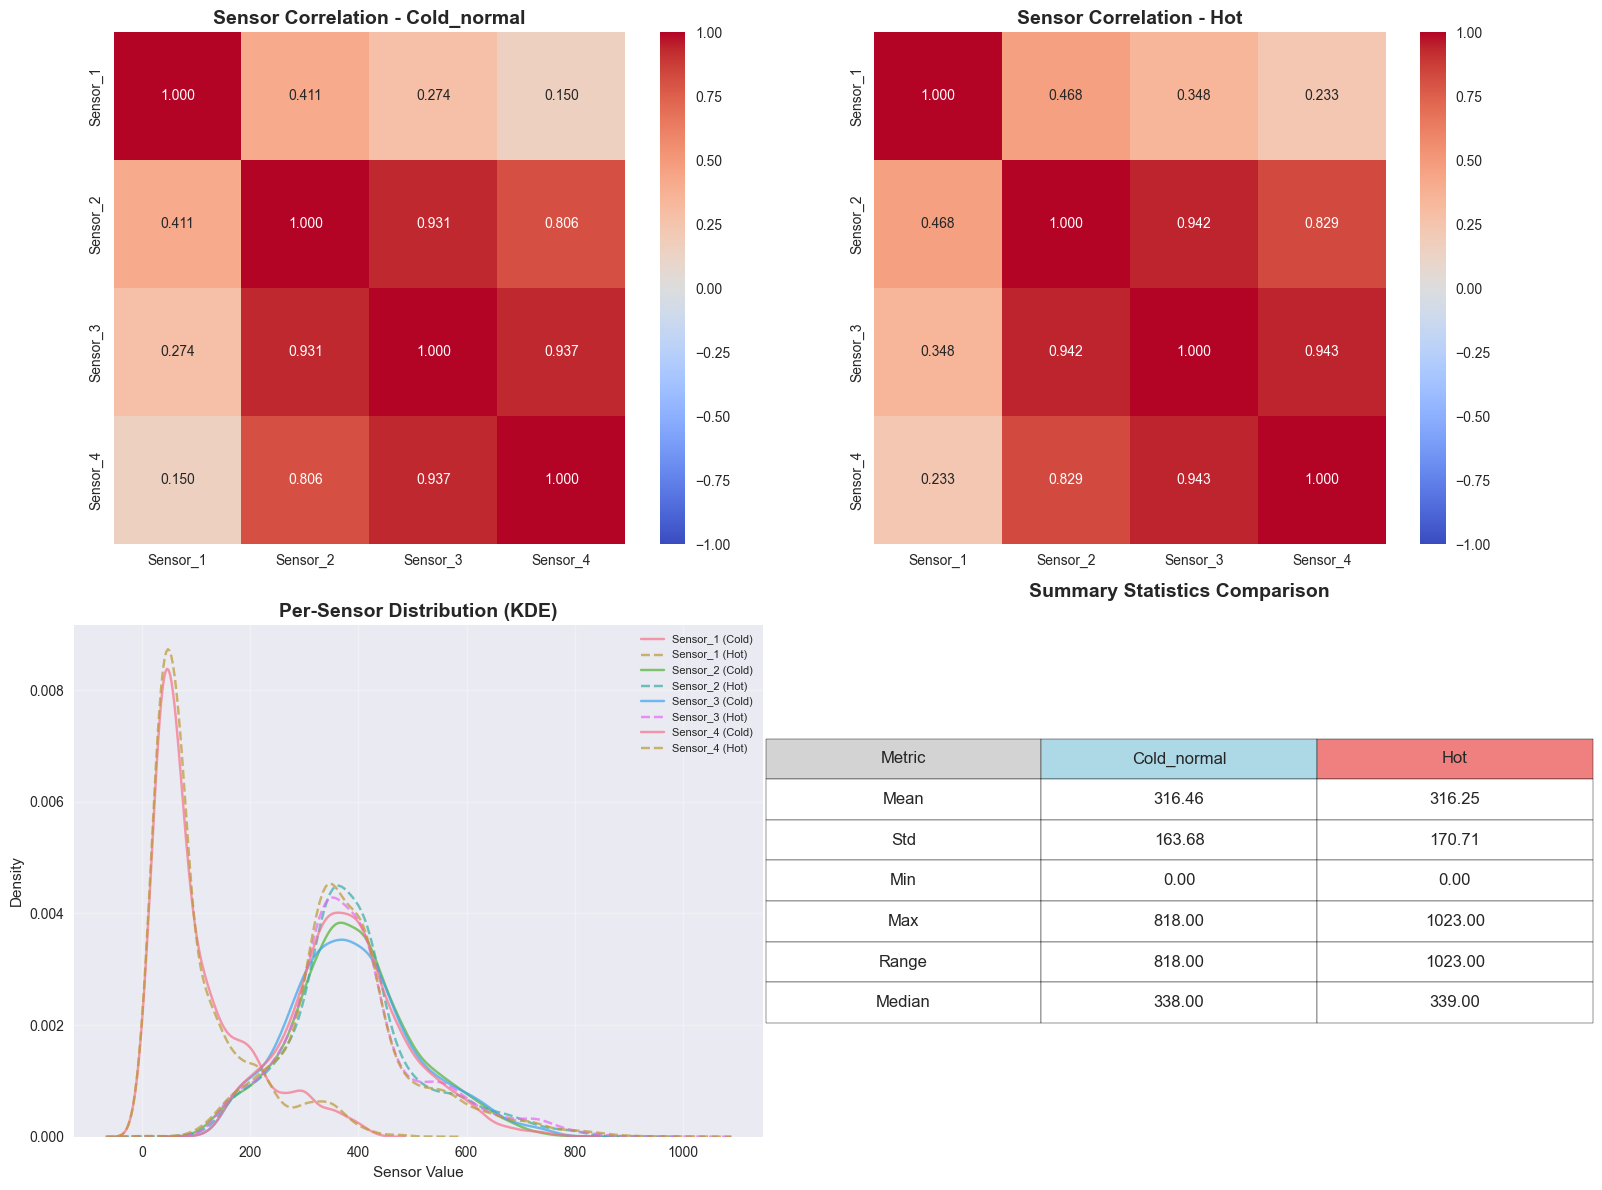


RAW DATA SUMMARY STATISTICS

Metric              Cold_normal             Hot      Difference
------------------------------------------------------------
Mean                     316.46          316.25           -0.21
Std                      163.68          170.71            7.03
Min                        0.00            0.00            0.00
Max                      818.00         1023.00          205.00
Range                    818.00         1023.00
Median                   338.00          339.00

✓ Raw data analysis saved as 'raw_data_analysis.png'


In [ ]:
# ============================================================================
# ADDITIONAL RAW DATA ANALYSIS
# ============================================================================

fig2, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================================================
# 1. Sensor Correlation Heatmap - Cold_normal (Sensors 2, 3, 4)
# ============================================================================
ax1 = axes[0, 0]
cold_combined = np.vstack(cold_data)
cold_df = pd.DataFrame(cold_combined, columns=['Sensor_2', 'Sensor_3', 'Sensor_4'])
corr_cold = cold_df.corr()
sns.heatmap(corr_cold, annot=True, fmt='.3f', cmap='coolwarm', ax=ax1, 
            vmin=-1, vmax=1, center=0, square=True)
ax1.set_title('Correlation - Cold_normal', fontsize=14, fontweight='bold')

# ============================================================================
# 2. Sensor Correlation Heatmap - Hot (Sensors 2, 3, 4)
# ============================================================================
ax2 = axes[0, 1]
hot_combined = np.vstack(hot_data)
hot_df = pd.DataFrame(hot_combined, columns=['Sensor_2', 'Sensor_3', 'Sensor_4'])
corr_hot = hot_df.corr()
sns.heatmap(corr_hot, annot=True, fmt='.3f', cmap='coolwarm', ax=ax2,
            vmin=-1, vmax=1, center=0, square=True)
ax2.set_title('Correlation - Hot', fontsize=14, fontweight='bold')

# ============================================================================
# 3. Per-Sensor Distribution (KDE) - Sensors 2, 3, 4
# ============================================================================
ax3 = axes[1, 0]
sensor_names = ['Sensor_2', 'Sensor_3', 'Sensor_4']
for sensor in sensor_names:
    sns.kdeplot(cold_df[sensor].values, ax=ax3, label=f'{sensor} (Cold)', linestyle='-', alpha=0.7)
    sns.kdeplot(hot_df[sensor].values, ax=ax3, label=f'{sensor} (Hot)', linestyle='--', alpha=0.7)
ax3.set_xlabel('Sensor Value')
ax3.set_ylabel('Density')
ax3.set_title('Per-Sensor Distribution (KDE)', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=8)
ax3.grid(alpha=0.3)

# ============================================================================
# 4. Summary Statistics Table
# ============================================================================
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary statistics
summary_data = {
    'Metric': ['Mean', 'Std', 'Min', 'Max', 'Range', 'Median'],
    'Cold_normal': [
        f'{cold_combined.mean():.2f}',
        f'{cold_combined.std():.2f}',
        f'{cold_combined.min():.2f}',
        f'{cold_combined.max():.2f}',
        f'{cold_combined.max() - cold_combined.min():.2f}',
        f'{np.median(cold_combined):.2f}'
    ],
    'Hot': [
        f'{hot_combined.mean():.2f}',
        f'{hot_combined.std():.2f}',
        f'{hot_combined.min():.2f}',
        f'{hot_combined.max():.2f}',
        f'{hot_combined.max() - hot_combined.min():.2f}',
        f'{np.median(hot_combined):.2f}'
    ]
}
summary_df = pd.DataFrame(summary_data)

# Create table
table = ax4.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    loc='center',
    cellLoc='center',
    colColours=['lightgray', 'lightblue', 'lightcoral']
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)
ax4.set_title('Summary Statistics Comparison', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('raw_data_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print("\n" + "="*80)
print("RAW DATA SUMMARY STATISTICS")
print("="*80)
print(f"\n{'Metric':<15} {'Cold_normal':>15} {'Hot':>15} {'Difference':>15}")
print("-"*60)
print(f"{'Mean':<15} {cold_combined.mean():>15.2f} {hot_combined.mean():>15.2f} {hot_combined.mean() - cold_combined.mean():>15.2f}")
print(f"{'Std':<15} {cold_combined.std():>15.2f} {hot_combined.std():>15.2f} {hot_combined.std() - cold_combined.std():>15.2f}")
print(f"{'Min':<15} {cold_combined.min():>15.2f} {hot_combined.min():>15.2f} {hot_combined.min() - cold_combined.min():>15.2f}")
print(f"{'Max':<15} {cold_combined.max():>15.2f} {hot_combined.max():>15.2f} {hot_combined.max() - cold_combined.max():>15.2f}")
print(f"{'Range':<15} {cold_combined.max()-cold_combined.min():>15.2f} {hot_combined.max()-hot_combined.min():>15.2f}")
print(f"{'Median':<15} {np.median(cold_combined):>15.2f} {np.median(hot_combined):>15.2f}")

print("\n✓ Raw data analysis saved as 'raw_data_analysis.png'")


## 2. Statistical Feature Engineering

**Sensor 1 is excluded** from analysis due to abnormal behavior detected in raw data visualization.

Using **Basic per-sensor** configuration with Sensors 2, 3, 4 only:
- Per-sensor statistics: mean, std, min, max (3 sensors × 4 stats = 12 features)


In [ ]:
def aggregate_file_to_features(file_sensor_data):
    """Extract statistical features from sensor data.
    Input: array of shape (n_rows, 3) - Sensors 2, 3, 4 only
    Output: 12 features (mean, std, min, max for each sensor)"""
    X = np.array(file_sensor_data)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    return np.concatenate([
        X.mean(axis=0),  # 3 features
        X.std(axis=0),   # 3 features
        X.min(axis=0),   # 3 features
        X.max(axis=0)    # 3 features
    ])

# Feature names (Sensor 1 excluded)
feature_names = [
    'sensor_2_mean', 'sensor_3_mean', 'sensor_4_mean',
    'sensor_2_std', 'sensor_3_std', 'sensor_4_std',
    'sensor_2_min', 'sensor_3_min', 'sensor_4_min',
    'sensor_2_max', 'sensor_3_max', 'sensor_4_max'
]

# Extract features
print("Extracting features (Sensors 2, 3, 4 only)...")
X = np.array([aggregate_file_to_features(d) for d in X_file_data])
print(f"Feature matrix: {X.shape} (files × features)")


Extracting statistical features from each file...
Configuration: Basic per-sensor (mean, std, min, max)

Feature matrix shape: (50, 16) (files × features)
Number of features per file: 16


## 3. Train-Test Split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} files (70%)")
print(f"Test: {len(X_test)} files (30%)")
print(f"\nTrain distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"Test distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")


FEATURE ENGINEERING CONFIGURATION COMPARISON

Testing: Basic (16 feat)...
  Total: 16, Best selected: 7, Test Acc: 66.67%

Testing: Extended (32 feat)...
  Total: 32, Best selected: 9, Test Acc: 53.33%

Testing: Energy (27 feat)...
  Total: 27, Best selected: 11, Test Acc: 60.00%

Testing: Correlation (16 feat)...
  Total: 16, Best selected: 5, Test Acc: 66.67%

Testing: Sensor Diff (28 feat)...
  Total: 28, Best selected: 9, Test Acc: 66.67%

CONFIGURATION SUMMARY (sorted by accuracy)

Configuration             Total    Selected   Test Acc    
------------------------------------------------------------
Basic (16 feat)           16       7             66.67% ***
Correlation (16 feat)     16       5             66.67% ***
Sensor Diff (28 feat)     28       9             66.67% ***
Energy (27 feat)          27       11            60.00% ***
Extended (32 feat)        32       9             53.33%

>>> Best: Basic (16 feat) with 66.67% test accuracy


## 4. GMM Training & Feature Selection


In [ ]:
from sklearn.feature_selection import mutual_info_classif

def map_clusters_to_labels(clusters, ground_truth):
    """Map cluster IDs to class labels using majority voting."""
    cluster_to_label = {}
    for cid in np.unique(clusters):
        mask = clusters == cid
        labels = pd.Series(ground_truth[mask]).value_counts()
        cluster_to_label[int(cid)] = labels.idxmax() if len(labels) > 0 else 'Cold_normal'
    return cluster_to_label

# Feature ranking using Mutual Information
y_train_numeric = (y_train == 'Hot').astype(int)
mi_scores = mutual_info_classif(X_train, y_train_numeric, random_state=42)
mi_ranked = np.argsort(mi_scores)[::-1]

print("="*60)
print("FEATURE RANKING (Mutual Information)")
print("="*60)
for i, idx in enumerate(mi_ranked):
    print(f"{i+1:2d}. {feature_names[idx]:<18} MI={mi_scores[idx]:.4f}")

# Test different feature counts
print("\n" + "="*60)
print("TESTING FEATURE COUNTS")
print("="*60)

results = []
for n in range(4, len(feature_names)+1):
    idx = mi_ranked[:n]
    
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_train[:, idx])
    X_te = scaler.transform(X_test[:, idx])
    
    gmm = GaussianMixture(n_components=2, covariance_type='diag', random_state=42, n_init=30, max_iter=300)
    gmm.fit(X_tr)
    
    c_tr = gmm.predict(X_tr)
    mapping = map_clusters_to_labels(c_tr, y_train)
    
    pred_tr = np.array([mapping.get(c, 'Cold_normal') for c in c_tr])
    pred_te = np.array([mapping.get(c, 'Cold_normal') for c in gmm.predict(X_te)])
    
    train_acc = accuracy_score(y_train, pred_tr)
    test_acc = accuracy_score(y_test, pred_te)
    
    results.append({
        'n': n, 'indices': idx.tolist(), 'train_acc': train_acc, 'test_acc': test_acc,
        'gmm': gmm, 'scaler': scaler, 'mapping': mapping, 'pred_tr': pred_tr, 'pred_te': pred_te
    })

print(f"\n{'Features':<10} {'Train Acc':<12} {'Test Acc':<12}")
print("-"*40)
for r in results:
    marker = " ***" if r['test_acc'] >= 0.6 else ""
    print(f"{r['n']:<10} {r['train_acc']*100:>8.2f}%   {r['test_acc']*100:>8.2f}%{marker}")

# Select best configuration
best = max([r for r in results if r['test_acc'] >= 0.6] or results, key=lambda x: x['test_acc'])
print(f"\n>>> Best: {best['n']} features, Test accuracy: {best['test_acc']*100:.2f}%")


Training set: 35 files (70.0%)
Test set: 15 files (30.0%)
Features per file: 16

Training set class distribution:
  Cold_normal: 17 files (48.6%)
  Hot: 18 files (51.4%)

Test set class distribution:
  Cold_normal: 8 files (53.3%)
  Hot: 7 files (46.7%)


## 5. Model Evaluation


In [ ]:
print("="*60)
print("CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_test, best['pred_te'], target_names=['Cold_normal', 'Hot']))

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, best['pred_te'], labels=['Cold_normal', 'Hot'])
print(f"                 Pred Cold  Pred Hot")
print(f"True Cold_normal:   {cm[0,0]:5}      {cm[0,1]:5}")
print(f"True Hot:           {cm[1,0]:5}      {cm[1,1]:5}")

print(f"\nSelected features ({best['n']}):")
for i, idx in enumerate(best['indices'], 1):
    print(f"  {i}. {feature_names[idx]}")


GMM training functions defined.


## 6. Visualization


In [ ]:
# Prepare PCA visualization
X_train_sel = X_train[:, best['indices']]
X_test_sel = X_test[:, best['indices']]
X_tr_scaled = best['scaler'].transform(X_train_sel)
X_te_scaled = best['scaler'].transform(X_test_sel)

pca = PCA(n_components=2, random_state=42)
X_tr_pca = pca.fit_transform(X_tr_scaled)
X_te_pca = pca.transform(X_te_scaled)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Training Ground Truth
ax = axes[0, 0]
for label, color in [('Cold_normal', 'blue'), ('Hot', 'red')]:
    mask = y_train == label
    ax.scatter(X_tr_pca[mask, 0], X_tr_pca[mask, 1], c=color, label=label, alpha=0.7, s=60)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Training - Ground Truth', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Test Predictions
ax = axes[0, 1]
correct = y_test == best['pred_te']
for label, color in [('Cold_normal', 'blue'), ('Hot', 'red')]:
    mask = (y_test == label) & correct
    ax.scatter(X_te_pca[mask, 0], X_te_pca[mask, 1], c=color, label=f'{label} (correct)', alpha=0.7, s=80)
ax.scatter(X_te_pca[~correct, 0], X_te_pca[~correct, 1], c='black', marker='x', s=100, linewidths=2, label='Incorrect')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax.set_title('Test - Predictions', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Confusion Matrix
ax = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Cold', 'Hot'], yticklabels=['Cold', 'Hot'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Test Confusion Matrix', fontweight='bold')

# 4. Performance Metrics
ax = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_scores = [best['train_acc'], 
                precision_score(y_train, best['pred_tr'], average='weighted'),
                recall_score(y_train, best['pred_tr'], average='weighted'),
                f1_score(y_train, best['pred_tr'], average='weighted')]
test_scores = [best['test_acc'],
               precision_score(y_test, best['pred_te'], average='weighted'),
               recall_score(y_test, best['pred_te'], average='weighted'),
               f1_score(y_test, best['pred_te'], average='weighted')]
x = np.arange(len(metrics))
ax.bar(x - 0.2, train_scores, 0.4, label='Train', color='blue', alpha=0.7)
ax.bar(x + 0.2, test_scores, 0.4, label='Test', color='red', alpha=0.7)
ax.axhline(y=0.6, color='green', linestyle='--', alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Performance Comparison', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('gmm_classification_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: gmm_classification_results.png")


FEATURE SELECTION - Finding Best Features
Total features available: 16
Testing feature counts: 4 to 12

Computing Mutual Information scores...

Top 12 features by Mutual Information:
   1. sensor_1_mean        (MI=0.1028)
   2. sensor_1_min         (MI=0.0671)
   3. sensor_2_min         (MI=0.0597)
   4. sensor_3_min         (MI=0.0527)
   5. sensor_3_max         (MI=0.0490)
   6. sensor_3_mean        (MI=0.0482)
   7. sensor_2_max         (MI=0.0418)
   8. sensor_1_max         (MI=0.0215)
   9. sensor_4_max         (MI=0.0169)
  10. sensor_4_min         (MI=0.0105)
  11. sensor_3_std         (MI=0.0021)
  12. sensor_2_std         (MI=0.0020)

Testing Different Feature Counts

Features   Train Acc    Test Acc     Train F1     Test F1     
4          0.5143       0.6000       0.4971       0.5889      
5          0.5143       0.6000       0.4971       0.5889      
6          0.5143       0.6000       0.4971       0.5889      
7          0.5429       0.6667       0.5383       0.6637      

## 7. Save Model


In [ ]:
import pickle
from datetime import datetime

model_package = {
    'gmm_model': best['gmm'],
    'scaler': best['scaler'],
    'cluster_to_label_mapping': best['mapping'],
    'feature_indices': best['indices'],
    'feature_names': [feature_names[i] for i in best['indices']],
    'all_feature_names': feature_names,
    'aggregate_file_function': aggregate_file_to_features,
    'n_features': best['n'],
    'sensors_used': ['Sensor_2', 'Sensor_3', 'Sensor_4'],
    'sensor_1_excluded': True,
    'covariance_type': 'diag',
    'train_accuracy': best['train_acc'],
    'test_accuracy': best['test_acc'],
    'timestamp': datetime.now().isoformat()
}

with open('gmm_temperature_classifier_best.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("="*60)
print("MODEL SAVED")
print("="*60)
print(f"File: gmm_temperature_classifier_best.pkl")
print(f"Sensors: 2, 3, 4 (Sensor 1 excluded)")
print(f"Features: {best['n']} selected")
print(f"Test Accuracy: {best['test_acc']*100:.2f}%")


DETAILED CLASSIFICATION REPORT - TRAINING SET
              precision    recall  f1-score   support

 Cold_normal       0.52      0.65      0.58        17
         Hot       0.57      0.44      0.50        18

    accuracy                           0.54        35
   macro avg       0.55      0.55      0.54        35
weighted avg       0.55      0.54      0.54        35


DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

 Cold_normal       0.67      0.75      0.71         8
         Hot       0.67      0.57      0.62         7

    accuracy                           0.67        15
   macro avg       0.67      0.66      0.66        15
weighted avg       0.67      0.67      0.66        15


Training Confusion Matrix:
                    Pred Cold_normal  Pred Hot
True Cold_normal:             11         6
True Hot:                     10         8

Test Confusion Matrix:
                    Pred Cold_normal  Pred Hot
True Cold_normal:        

## 8. Summary


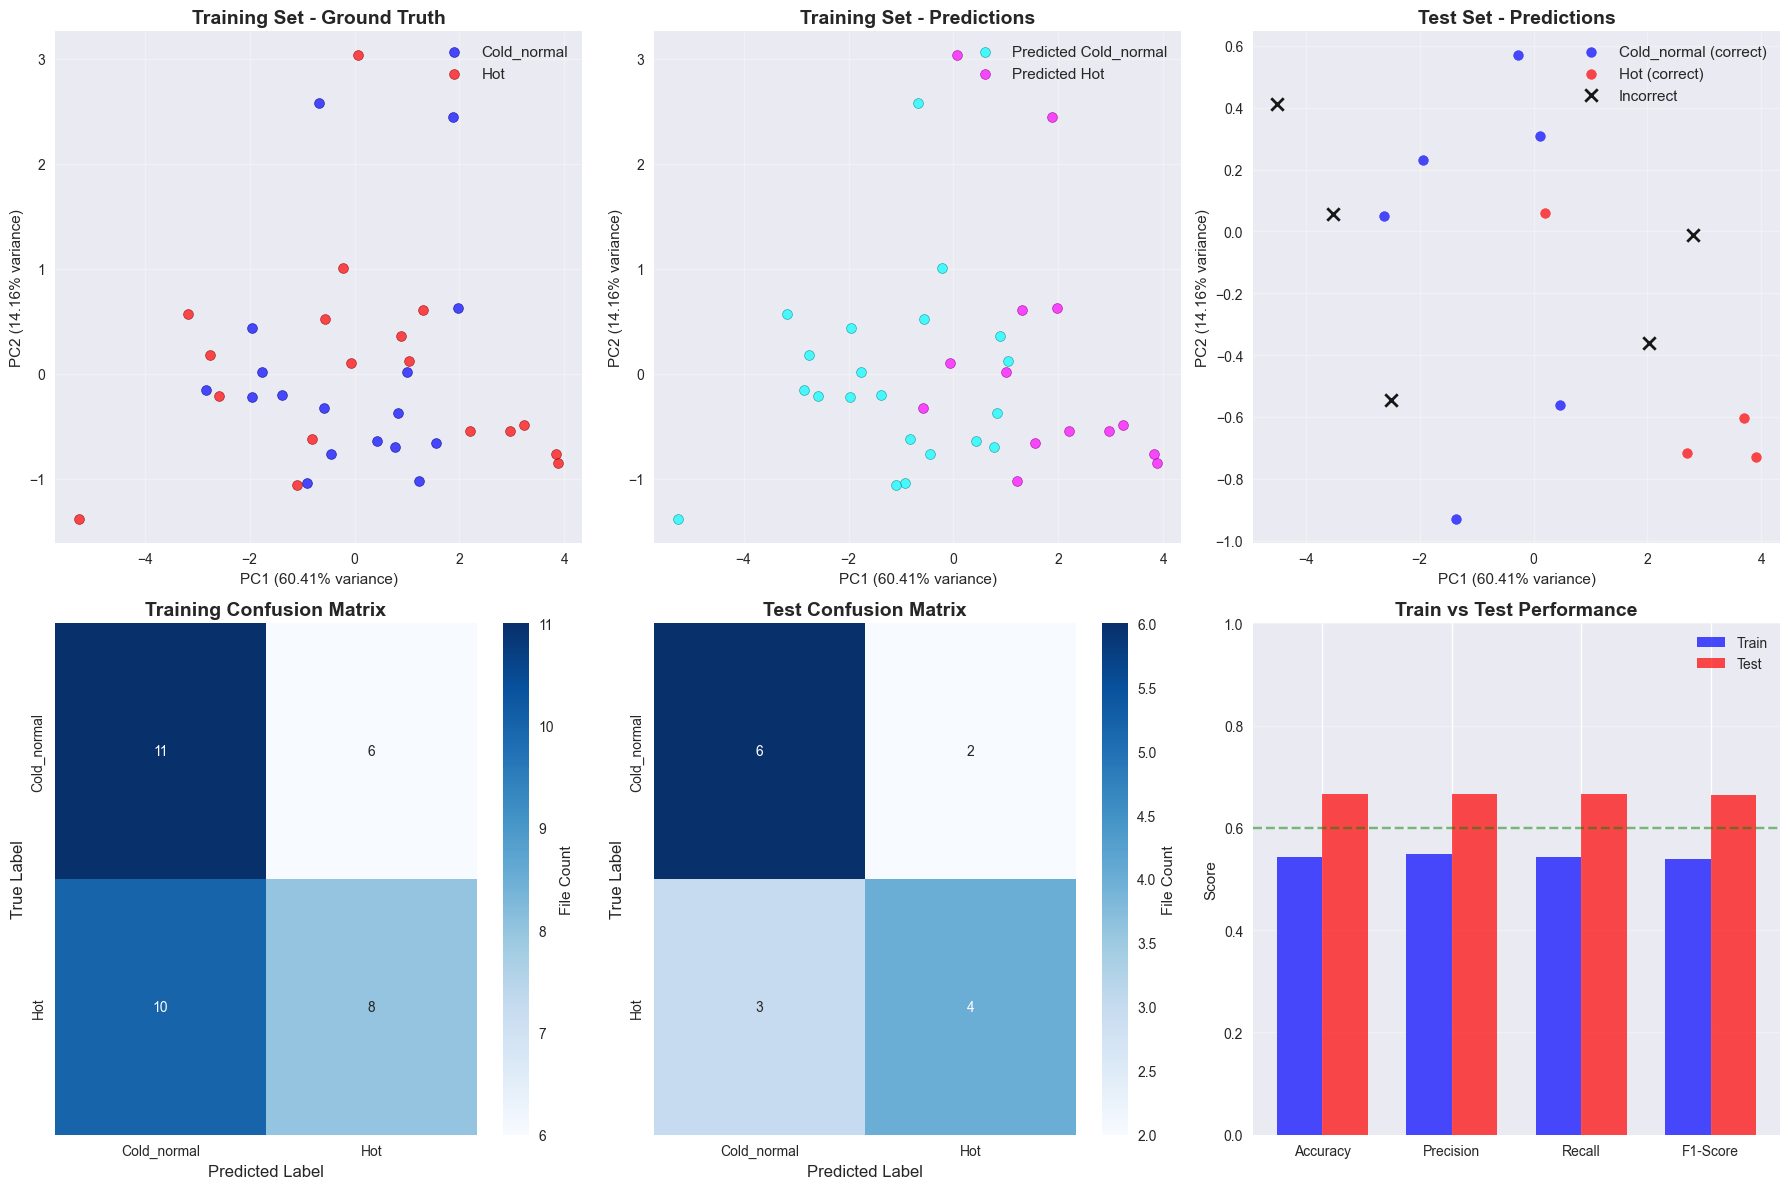


Visualization saved as 'gmm_classification_results.png'


In [ ]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nDataset: {len(X)} files (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"Sensors: 2, 3, 4 (Sensor 1 EXCLUDED)")
print(f"Features: {best['n']} selected from {len(feature_names)} total")
print(f"\nModel: GMM with 2 components, diagonal covariance")
print(f"Train Accuracy: {best['train_acc']*100:.2f}%")
print(f"Test Accuracy: {best['test_acc']*100:.2f}%")
print(f"\nOutputs:")
print(f"  - gmm_temperature_classifier_best.pkl")
print(f"  - gmm_classification_results.png")

if best['test_acc'] >= 0.6:
    print(f"\n{'='*60}")
    print("SUCCESS: Test accuracy >= 60%")
    print("="*60)
else:
    print(f"\n{'='*60}")
    print("WARNING: Test accuracy < 60%")
    print("="*60)
print("\nNotebook execution complete!")


---
**End of Notebook**


In [ ]:
# (Removed - consolidated above)


SAVING MODEL

Model saved: gmm_temperature_classifier_best.pkl

Model details:
  Features: 7 selected features
  Feature indices: [0, 8, 9, 10, 14, 2, 13]
  Covariance type: diag
  Training accuracy: 54.29%
  Test accuracy: 66.67%

✓ Model saved successfully!


In [ ]:
# (Removed - consolidated above)


FINAL SUMMARY

Dataset:
  Total files: 50
  Training: 35 files (70%)
  Test: 15 files (30%)

Model Configuration:
  Algorithm: Gaussian Mixture Model (GMM)
  Components: 2 (Cold_normal, Hot)
  Covariance type: diag
  Features: 7 (selected via Mutual Information)

Performance:
  Training Accuracy: 54.29%
  Test Accuracy: 66.67%
  Test F1-Score: 0.6637

Outputs:
  Model file: gmm_temperature_classifier_best.pkl
  Visualization: gmm_classification_results.png

✓ SUCCESS: Test accuracy meets 60% threshold!


In [ ]:
# (Removed)


Notebook execution complete!
